# Example 1 - Map of chlorophyll content in the North West Atlantic

This example shows how to read and manipulate Argo profiles data stored in your machine in the parquet format.

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

### Note on performance
The performance should be similar to the times I have reported in the example below as long as it is run on Google Colab. I also report speeds for tests run locally with the code and the data on the same machine, which are faster. A hybrid solution with code and data close to one another but stored in the cloud is under development.

### Note on parquet files
The original netCDF Argo files have been converted to parquet format, which provides faster read operations. For example we can provide filters upon reading, and the dedicated libraries will sort through the database and load into memory only the subset that satisfies your filters.

There are a couple of libraries to read parquet files in Python. In the first part of the example we will use [pyarrow](https://arrow.apache.org/docs/python/index.html) and [pandas](https://pandas.pydata.org/docs/index.html), in the second part [dask](https://docs.dask.org/en/stable/). Dask is a library that allows parallelized lazy evaluation: it first builds the graph of the operation, and then executes it as late as possible so it can optmize it. Its basic grammar is by design almost identical to pandas', and it outperforms the pyarrow-pandas approach, so I recommend checking it out even if it requires a bit more of learning.

Generally speaking, you'll want to use Dask whenever you need a larger-than-memory amount of data, so that you can benefit from its capabilities to handle that. You can avoid Dask whenever the data fits in your RAM.

## Getting started

We start by importing the necessary modules and setting the path and filenames of the parquet files. We also provide the schema (e.g. column names and data types) that pyarrow will need to read the parquet database. This speeds up read operations, as pyarrow does not need to guess the schema from the files.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
from pprint import pprint

# Path to parquet database
parquet_dir = '../data/parquet/bgc/'

# Setting up parquet schema
schema_path = '../schemas/ArgoBGC_allParams_schema.metadata'
BGC_schema = pq.read_schema(schema_path)

# We import argopy only for speed comparisons
import argopy
argopy.reset_options()
argopy.set_options(
    dataset='bgc',
    mode='expert'
)

## pyarrow-pandas approach 

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention.

In [2]:
dataset = pq.ParquetDataset(parquet_dir, schema=BGC_schema)
schema = dataset.schema
pprint(sorted(schema.names))

['BBP',
 'BBP470',
 'BBP470_ADJUSTED',
 'BBP470_ADJUSTED_ERROR',
 'BBP470_ADJUSTED_QC',
 'BBP470_QC',
 'BBP470_dPRES',
 'BBP532',
 'BBP532_ADJUSTED',
 'BBP532_ADJUSTED_ERROR',
 'BBP532_ADJUSTED_QC',
 'BBP532_QC',
 'BBP532_dPRES',
 'BBP700',
 'BBP700_ADJUSTED',
 'BBP700_ADJUSTED_ERROR',
 'BBP700_ADJUSTED_QC',
 'BBP700_QC',
 'BBP700_dPRES',
 'BBP_ADJUSTED',
 'BBP_ADJUSTED_ERROR',
 'BBP_ADJUSTED_QC',
 'BBP_QC',
 'BBP_dPRES',
 'BISULFIDE',
 'BISULFIDE_ADJUSTED',
 'BISULFIDE_ADJUSTED_ERROR',
 'BISULFIDE_ADJUSTED_QC',
 'BISULFIDE_QC',
 'BISULFIDE_dPRES',
 'CDOM',
 'CDOM_ADJUSTED',
 'CDOM_ADJUSTED_ERROR',
 'CDOM_ADJUSTED_QC',
 'CDOM_QC',
 'CDOM_dPRES',
 'CHLA',
 'CHLA_ADJUSTED',
 'CHLA_ADJUSTED_ERROR',
 'CHLA_ADJUSTED_QC',
 'CHLA_QC',
 'CHLA_dPRES',
 'CP',
 'CP660',
 'CP660_ADJUSTED',
 'CP660_ADJUSTED_ERROR',
 'CP660_ADJUSTED_QC',
 'CP660_QC',
 'CP660_dPRES',
 'CP_ADJUSTED',
 'CP_ADJUSTED_ERROR',
 'CP_ADJUSTED_QC',
 'CP_QC',
 'CP_dPRES',
 'CYCLE_NUMBER',
 'DOWNWELLING_PAR',
 'DOWNWELLING_PAR_

We now want to set up our filter to read only the data for the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -45$^\circ$ and -78$^\circ$).

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`.

In [3]:
filter_coords = [("LATITUDE",">",34), ("LATITUDE","<",80),
                 ("LONGITUDE",">",-78), ("LONGITUDE","<",-50)]

To get a pandas dataframe, we need first to create a parquet dataset that pyarrow can read with `ParquetDataset()`, then we read it into a pandas dataframe with `read().to_pandas()` methods of the dataset. The filters are applied when `ParquetDataset()` is called.

**NB:** The following operation still fetches a large amount of data (~12 GB), so you can skip executing it if your machine does not have enough memory.

In [4]:
%%time
ds = pq.ParquetDataset(
    parquet_dir, 
    schema=BGC_schema, 
    filters=filter_coords
)
df = ds.read().to_pandas()
df

CPU times: user 1min 26s, sys: 1min 8s, total: 2min 34s
Wall time: 7.76 s


,JULD,PLATFORM_NUMBER,N_PROF,N_LEVELS,CYCLE_NUMBER,LATITUDE,LONGITUDE,POSITION_QC,JULD_QC,PRES,...,UP_IRRADIANCE555_dPRES,UP_IRRADIANCE555_ADJUSTED,UP_IRRADIANCE555_ADJUSTED_QC,UP_IRRADIANCE555_ADJUSTED_ERROR,DOWNWELLING_PAR,DOWNWELLING_PAR_QC,DOWNWELLING_PAR_dPRES,DOWNWELLING_PAR_ADJUSTED,DOWNWELLING_PAR_ADJUSTED_QC,DOWNWELLING_PAR_ADJUSTED_ERROR
0,2011-10-15 21:05:09.999847680,1901378,154,0,155,34.025000,-69.40500,1,1,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-10-15 21:05:09.999847680,1901378,154,1,155,34.025000,-69.40500,1,1,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-10-15 21:05:09.999847680,1901378,154,2,155,34.025000,-69.40500,1,1,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-10-15 21:05:09.999847680,1901378,154,3,155,34.025000,-69.40500,1,1,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-10-15 21:05:09.999847680,1901378,154,4,155,34.025000,-69.40500,1,1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13030750,2024-09-06 15:33:00.000000000,4902688,59,1459,37,59.399712,-51.06638,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
13030751,2024-09-06 15:33:00.000000000,4902688,59,1460,37,59.399712,-51.06638,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
13030752,2024-09-06 15:33:00.000000000,4902688,59,1461,37,59.399712,-51.06638,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
13030753,2024-09-06 15:33:00.000000000,4902688,59,1462,37,59.399712,-51.06638,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN


You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

The function above took a few seconds on WHOI's cluster. Let's verify how much data has been loaded:

In [5]:
print( str( df.memory_usage().sum()*1e-9 ) + " GB.")

12.248909828 GB.


We now want to compare this timing with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception after 1 minute (if it doesn't, let me know!). This is likely due to ERDAP's servers timing out after that time (as the wall time consistently measures).

In [6]:
%%time
f = argopy.DataFetcher()
f = f.region([-78, -50, 34, 80, 0, 10000])
try:
    f.load()
except Exception as e:
    print(f"Exception: {e}")

Exception: 
CPU times: user 1.06 s, sys: 130 ms, total: 1.19 s
Wall time: 1min 5s


We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data is faster. Of course this is due to our Argo mirror being on the same machine where the code is executed. We are also working on a cloud-based mirror and the first results are promising.

Now let's narrow the filters in time and depth -- let's say we we want to select the data recorded in the year 2023, and measured between 100 and 300 db. As pyarrow does not allow to filter out NaNs automatically, we simply impose a very wide range of values.

The resulting pandas dataframe will now be much smaller (~64 MB).

In [7]:
from datetime import datetime
t0 = datetime(2023, 1, 1)
t1 = datetime(2023, 12, 31)
# reference_time = datetime.utcnow() - timedelta(days=90)
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">=",t0),("JULD","<=",t1),
                           ("PRES_ADJUSTED",">=",100),("PRES_ADJUSTED","<=",300),
                           ("CHLA_ADJUSTED",">=",-1e30),("CHLA_ADJUSTED","<=",+1e30)]

t0_argopy = t0.strftime('%Y-%m')
t1_argopy = t1.strftime('%Y-%m')
f = argopy.DataFetcher()
f = f.region([-78, -50, 34, 80, 100, 300, t0_argopy, t1_argopy])

In [8]:
%%time
ds = pq.ParquetDataset(parquet_dir, schema=BGC_schema, filters=filter_coords_time_pres)
df = ds.read().to_pandas()

print( "Memory usage: " + str( df.memory_usage().sum()*1e-6 ) + " MB.")

Memory usage: 64.60673799999999 MB.
CPU times: user 40.5 s, sys: 6.04 s, total: 46.5 s
Wall time: 2.9 s


In [9]:
%%time
try:
    f.load()
except Exception as e:
    print(f"Exception: {e}")

Exception: ''
CPU times: user 15.3 ms, sys: 137 ms, total: 152 ms
Wall time: 34.5 s


It now took approximately 3 seconds for our Argo mirror, and while the ERDDAP's servers threw an exception.

NB: of course the fast reading is also due to our Argo mirror being on the same machine where the code is executed. We are also working on a cloud-based mirror and the first results are promising.

#### Map

As in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates). We do this through the variable `columns` of `read_parquet()`.

In [10]:
%%time
ref_var = 'CHLA_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">=",t0),("JULD","<=",t1),
                           ("PRES_ADJUSTED",">=",100),("PRES_ADJUSTED","<=",300),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30)]
ds = pq.ParquetDataset(
    parquet_dir, 
    schema=BGC_schema, 
    filters=filter_coords_time_pres
)
df = ds.read(columns=cols).to_pandas()

CPU times: user 6.48 s, sys: 631 ms, total: 7.11 s
Wall time: 1.26 s


This took around 15 seconds in total. Let's see what it's loaded:

In [11]:
print( "Memory usage: " + str( df.memory_usage().sum()*1e-6 ) + " MB.")

Memory usage: 2.302368 MB.


In [12]:
df

,CHLA_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED,JULD
0,0.171550,34.274000,-68.8150,101.860001,2023-03-19 04:08:48.000440832
1,0.167900,34.274000,-68.8150,112.200005,2023-03-19 04:08:48.000440832
2,0.153300,34.274000,-68.8150,121.720001,2023-03-19 04:08:48.000440832
3,0.160600,34.274000,-68.8150,131.750000,2023-03-19 04:08:48.000440832
4,0.124100,34.274000,-68.8150,141.559998,2023-03-19 04:08:48.000440832
...,...,...,...,...,...
71940,0.011549,72.940977,-65.6388,296.796295,2023-08-28 15:35:39.964962304
71941,0.005785,72.940977,-65.6388,297.542389,2023-08-28 15:35:39.964962304
71942,0.009125,72.940977,-65.6388,298.288483,2023-08-28 15:35:39.964962304
71943,0.010658,72.940977,-65.6388,298.951660,2023-08-28 15:35:39.964962304


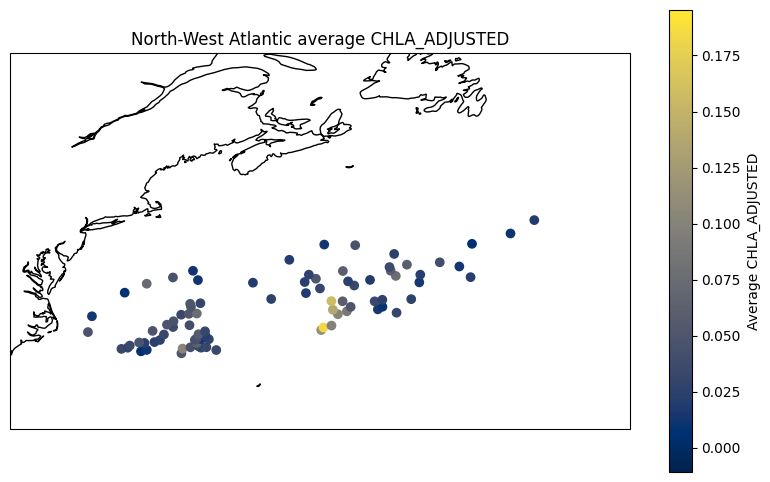

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = df[ref_var].quantile(q=0.01)
cbar_max = df[ref_var].quantile(q=0.99)
plt.scatter(grouped['LONGITUDE'], grouped['LATITUDE'], c=grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([-78, -45])
plt.ylim([30, 50])
plt.show()

## Dask approach

Dask can be faster at reading parquet databases thanks to its parallel and lazy evaluation of operations. When coding with it, few things change. Dask dataframes are almost identical to pandas dataframes and indeed for our needs we will use the same syntax! The only difference is that dask does not evaluate the instructions immediately: it creates so-called delayed objects, through which it builds internally a graph of instructions optimized for the sequence of operations called. To trigger the actual computation we then need to call the `compute()` method of the dask dataframe. This allows dask to handle larger-than-memory datasets, by reading into memory only the portions needed to perform the optimized set of instructions.

We start by importing the necessary modules.

In [15]:
import dask
import dask.dataframe as dd

We can use the same filters defined earlier, and we use `read_parquet()` to filter the database and prescribe what we will need.
Note that:
* unlike the pyarrow-pandas approach, here we provide both filters and columns in the same method;
* we provide the schema `BGC_schema` that we read during the set up of the excercise
* dask uses pyarrow under the hood (`engine` variable, other options are available)

In [16]:
%%time
ref_var = 'CHLA_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">=",t0),("JULD","<=",t1),
                           ("PRES_ADJUSTED",">=",100),("PRES_ADJUSTED","<=",300),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30)]

ddf = dd.read_parquet(
    parquet_dir,
    engine="pyarrow",
    storage_options={"anon": True, "use_ssl": True} ,
    schema=BGC_schema,
    filters=filter_coords_time_pres,
    columns= cols
    )

CPU times: user 203 ms, sys: 109 ms, total: 312 ms
Wall time: 315 ms


It appears dask is much faster! Yet, it actually creates a delayed object, i.e. `ddf` contains the instruction that dask will later use to load the dataframe into memory. This allows us to use `ddf` to schedule all the operations that we'd normally perform on a dataframe. Eventually we will call `ddf.compute()` to actually evaluate the instructions.

If we look at `ddf`, the dataframe will in fact appear empty:

In [17]:
ddf

,CHLA_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED,JULD
npartitions=59,,,,,
,float32,float64,float64,float32,datetime64[ns]
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


We can explore its first entries with `head()`, which loads into memory only the first 5 entries:

In [18]:
ddf.head()

,CHLA_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED,JULD
0,0.079251,35.9943,-73.6386,101.720001,2023-04-05 06:33:50.000691200
1,0.035950,35.9943,-73.6386,103.720001,2023-04-05 06:33:50.000691200
2,0.038401,35.9943,-73.6386,105.720001,2023-04-05 06:33:50.000691200
3,0.041669,35.9943,-73.6386,107.720001,2023-04-05 06:33:50.000691200
4,0.040035,35.9943,-73.6386,109.720001,2023-04-05 06:33:50.000691200


### Timing

To load the whole dataframe, we call `compute()`. This is not the recommended time to load the data into memory when our goal is to make a map, but we do it to test dask's reading speed.

In [19]:
%%time
ddf_loaded = ddf.compute()

CPU times: user 1.36 s, sys: 522 ms, total: 1.88 s
Wall time: 302 ms


It is indeed much faster than the pyarrow+pandas approach! We can have confirmation that the data was fetched by inspecting the dataframe:

In [20]:
ddf_loaded

,CHLA_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED,JULD
0,0.079251,35.994300,-73.6386,101.720001,2023-04-05 06:33:50.000691200
1,0.035950,35.994300,-73.6386,103.720001,2023-04-05 06:33:50.000691200
2,0.038401,35.994300,-73.6386,105.720001,2023-04-05 06:33:50.000691200
3,0.041669,35.994300,-73.6386,107.720001,2023-04-05 06:33:50.000691200
4,0.040035,35.994300,-73.6386,109.720001,2023-04-05 06:33:50.000691200
...,...,...,...,...,...
569,0.011549,72.940977,-65.6388,296.796295,2023-08-28 15:35:39.964962304
570,0.005785,72.940977,-65.6388,297.542389,2023-08-28 15:35:39.964962304
571,0.009125,72.940977,-65.6388,298.288483,2023-08-28 15:35:39.964962304
572,0.010658,72.940977,-65.6388,298.951660,2023-08-28 15:35:39.964962304


### Map

When producing the map with our dask approach, we would creat the `grouped` dataframe from the delayed dataframe `ddf`, and `compute()` it as late as possible.

In this example, the compute that we are triggering includes four operations:
* reading the filtered dataset;
* grouping the dataframe by geographical coordinates;
* averaging by pressure;
* resetting the index;

Dask internally builds a graph of all of these operations, so that it knows what subset of data is needed and it optimizes the number and sequence of instructions before executing them.

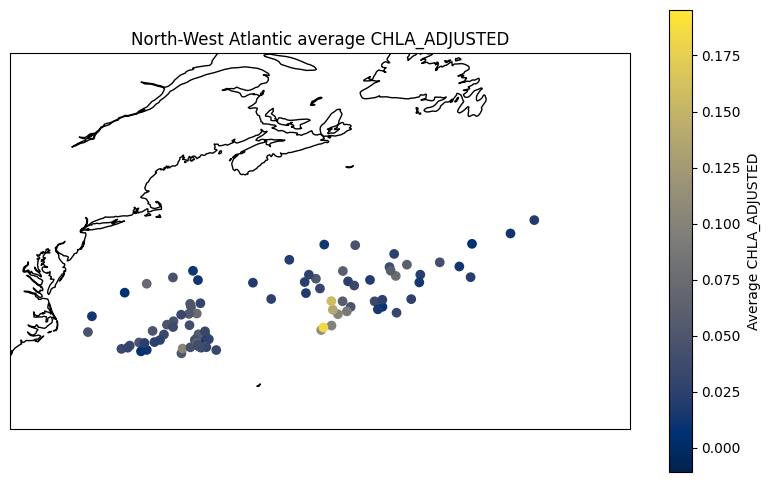

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED'
grouped = ddf.groupby(['LATITUDE', 'LONGITUDE']).agg({
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

grouped = grouped.compute()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
plt.scatter(
    grouped['LONGITUDE'],
    grouped['LATITUDE'],
    c=grouped[ref_var],
    vmin=cbar_min,
    vmax=cbar_max,
    cmap='cividis',
    transform=ccrs.PlateCarree()
)
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([-78, -45])
plt.ylim([30, 50])
plt.show()

## Exercise

Try and access some other metadata, for example:
* filtering by different time periods;
* mapping a different parameter;
* restraining the quality of the data further by imposing QC=1 only;
* performing reads/manipulations that you would need to perform your tasks.

If you encounter any issues, please [reach out](enrico.milanese@whoi.edu)!